In [3]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib as mpl
from tqdm import tqdm

import plotly.offline as plo
import plotly.graph_objs as go

from python_scripts.tube import tube
from python_scripts import util

# customize matplotlib styles
mpl.rc('lines', linewidth=4) # default linewidth
mpl.rc('lines', dash_capstyle='round') # default dashed line capstyle
mpl.rc('lines', solid_capstyle='round') # default solid line capstyle
mpl.rc('xtick', labelsize=20) # default label size for xtick
mpl.rc('ytick', labelsize=20) # default label size for ytick
mpl.rc('axes', titlesize=30) # default title size
mpl.rc('axes', labelsize=25) # default label size for all axes
mpl.rc('legend', fontsize=20) # default fontsize for legends
mpl.rc('figure', titlesize=35) # default title size for figures with subplot

% matplotlib inline

# Check height of tubes

In [4]:
directory = os.path.expanduser("~/research/cnt_mesh_fiber")

tubes = []

for i in range(1,100):
    filename = os.path.join(directory, "tube"+str(i)+".pos.dat")
    if (not os.path.isfile(filename)):
        continue
    print("reading file: {}".format(filename))
    with open(filename) as file:
        for line in file:
            r = line.strip().split(";")
            r = r[1:]
            tubes.append(tube(r))

# # make sure the last tube is stored and read properly
# if (tubes[-1].r.shape!=tubes[0].r.shape): tubes.pop(-1)

n=0;
for t in tubes:
    n += t.r.shape[0]
print("total number of bodies: {}".format(n))
            
print("number of tubes: {}".format(len(tubes)))
avg_y = np.array([tube.avg_y() for tube in tubes[:]])

avg_number_of_sections = np.mean([tube.r.shape[0] for tube in tubes])
print("average number of sections per tube: {}".format(int(avg_number_of_sections)))

reading file: /Users/amirhossein/research/cnt_mesh_fiber/tube1.pos.dat
total number of bodies: 62685
number of tubes: 3790
average number of sections per tube: 16


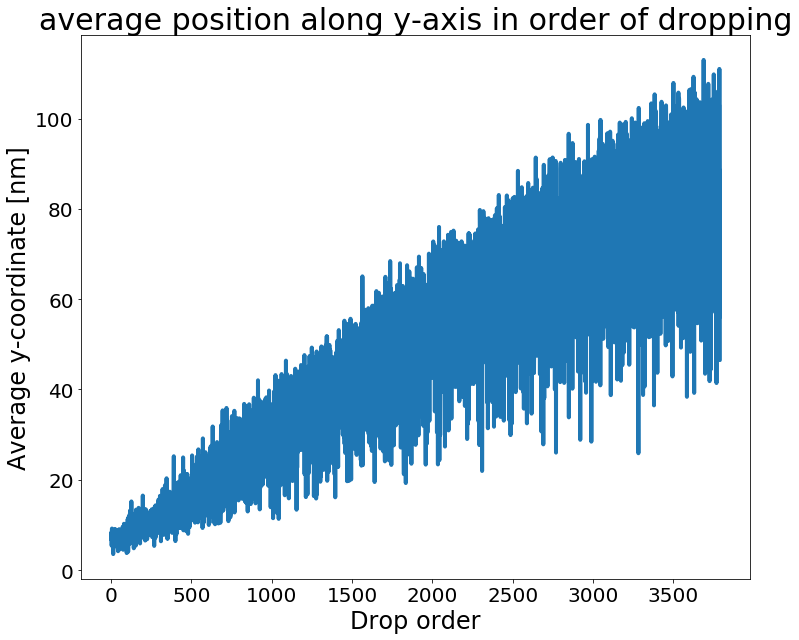

In [5]:
min_order, max_order = 0, len(tubes)
drop_order = np.linspace(min_order,max_order, max_order-min_order)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.plot(drop_order,avg_y[min_order:max_order], linewidth=4)
ax.set_title("average position along y-axis in order of dropping",fontsize=30)
ax.set_xlabel("Drop order",fontsize=24)
ax.set_ylabel("Average y-coordinate [nm]",fontsize=24)
ax.tick_params(labelsize=20)

# Plot CNT fiber using Plotly

In [6]:
data = []
for t in tubes[0:10]:

    trace = go.Scatter3d(
        x=t.z(), y=t.x(), z=t.y(),
        marker=dict(
            size=0,
            colorscale='Viridis',
        ),
        line=dict(
            width=1
        )
    )
    
    data.append(trace)


layout = dict(
#     width=800,
#     height=700,
    autosize=True,
    title='Iris dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.02 ),
        aspectmode = 'manual'
    ),
)

fig = go.Figure(data=data, layout=layout)
plo.plot(fig,filename=os.path.join(directory,"temp-pyplot.html"))

'file:///Users/amirhossein/research/cnt_mesh_fiber/temp-pyplot.html'

# Draw individual CNTs in the container

Text(0,0.5,'[nanometers]')

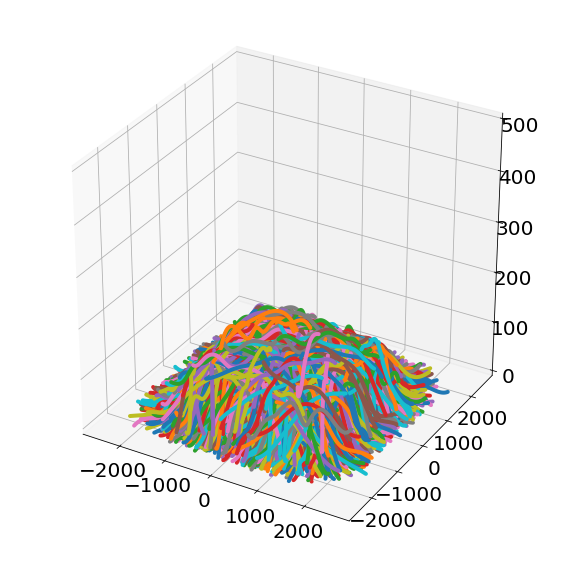

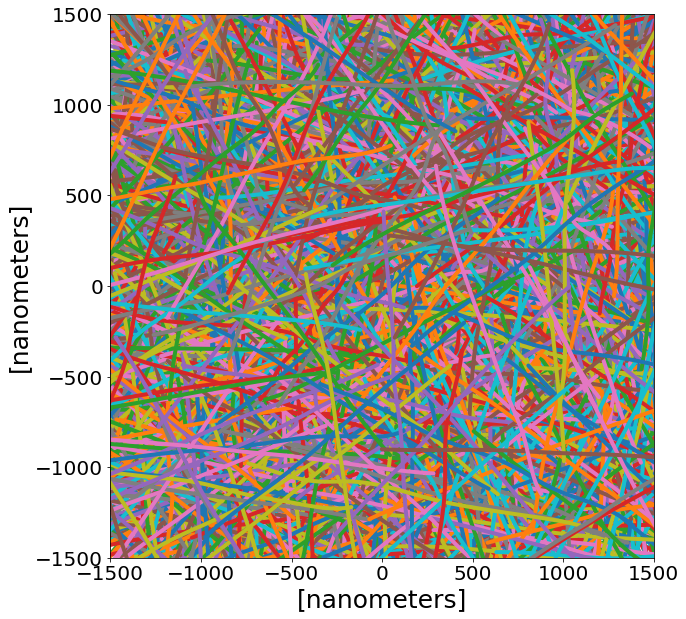

In [19]:
# plot a 3D view of the mesh
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,projection='3d')
ax.set_aspect('equal')

begin=0
n_tube=len(tubes)

for t in tubes[begin:begin+n_tube]:
    ax = t.plot(ax=ax,mode='fine')

# ax.set_xlim([-2000,2000])
# ax.set_ylim([-2000,2000])
_ = ax.set_zlim([0,500])

# plot a top view of the mesh
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

begin=0
n_tube=len(tubes)

for t in tubes[begin:begin+n_tube]:
    ax.plot(t.r_fine()[:,2], t.r_fine()[:,0])
    
# for t in tubes[begin:begin+n_tube]:
#     ax.plot(t.r[:,2], t.r[:,0])
    
ax.set_xlim([-1500, 1500])
ax.set_ylim([-1500, 1500])
ax.set_xlabel("[nanometers]")
ax.set_ylabel("[nanometers]")

# Working with quaternions for rations

Rotation is three dimension as a rotation by around axis $\vec{b}$ by angle $\alpha$. We can specify the rotation axis via [direction cosines](https://en.wikipedia.org/wiki/Direction_cosine)

$$ \cos(\beta_x) = \frac{\vec{b}.\hat{x}}{|b|} \quad,\quad \cos(\beta_y) = \frac{\vec{b}.\hat{y}}{|b|} \quad,\quad \cos(\beta_z) = \frac{\vec{b}.\hat{z}}{|b|} $$

Therefore, the quaternion elements, $\pmb{q}=[q_0, q_1, q_2, q_3]^T$, are given by 

$$
\begin{split}
q_0 = & ~\cos(\alpha/2) \\
q_1 = & ~\sin(\alpha/2) \cos(\beta_x) \\
q_2 = & ~\sin(\alpha/2) \cos(\beta_y) \\
q_3 = & ~\sin(\alpha/2) \cos(\beta_z) \\
\end{split}
$$

The rotation matrix for normalized quaternion is
$$
R = \begin{bmatrix}
q_0^2 + q_1^2 - q_2^2 - q_3^2 &  2(q_1 q_2 - q_0 q_3) &  2(q_0 q_2 + q_1 q_3) \\
2(q_1 q_2 + q_0 q_3) & q_0^2 - q_1^2 + q_2^2 - q_3^2 &  2(q_2 q_3 - q_0 q_1) \\
2(q_1 q_3 - q_0 q_2) & 2( q_0 q_1 + q_2 q_3) & q_0^2 - q_1^2 - q_2^2 + q_3^2 
\end{bmatrix}
$$



References:
- https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles

In [6]:
axis = np.array([0,1,0])
alpha = 0
qt = util.get_quaternion(axis,alpha)
Rot  = util.rotation_from_quaternion(qt)

v = np.array([1,0,0])
v = np.reshape(v,(3,1))
w = np.matmul(Rot,v)
print(w)


[[1.]
 [0.]
 [0.]]


## Check distance between interpolated coordinates of CNT fibers

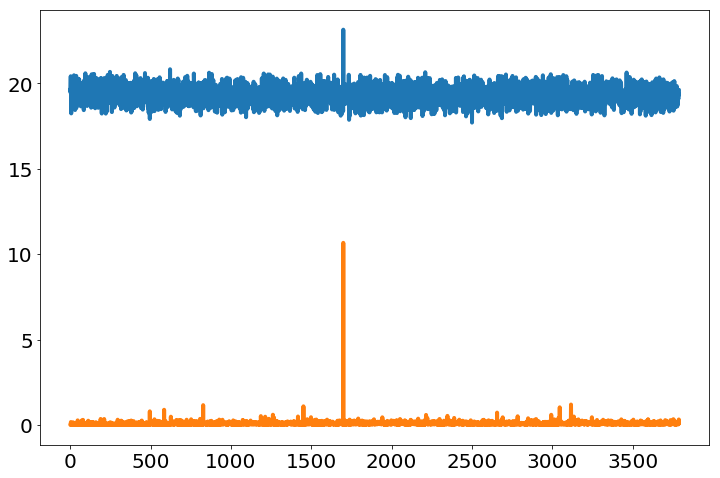

In [7]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

m = []
std = []

for t in tubes[:-1]:
    dr = t.r_fine()[0:-2,:]-t.r_fine()[1:-1,:]
    dr = np.linalg.norm(dr,axis=1)
    m.append(np.mean(dr))
    std.append(np.std(dr))

ax.plot(m)
ax.plot(std)


## Minimum distance distribution in the network

100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s]


Text(0,0.5,'Probability distribution')

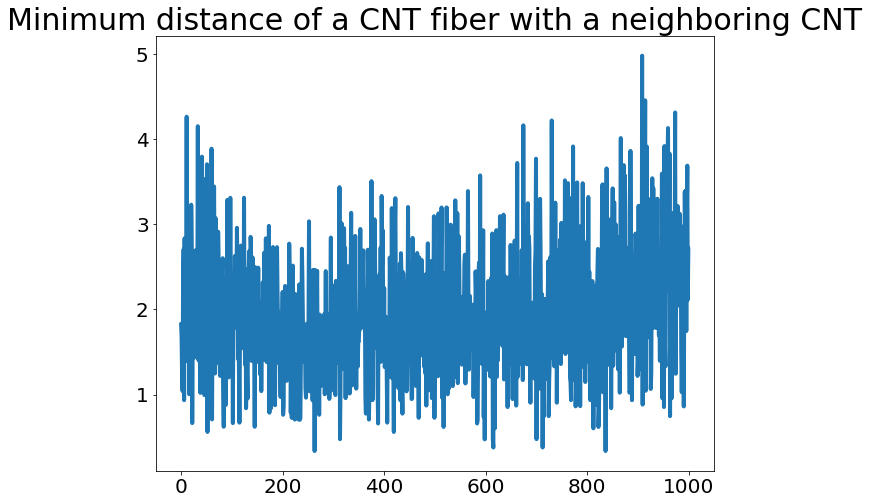

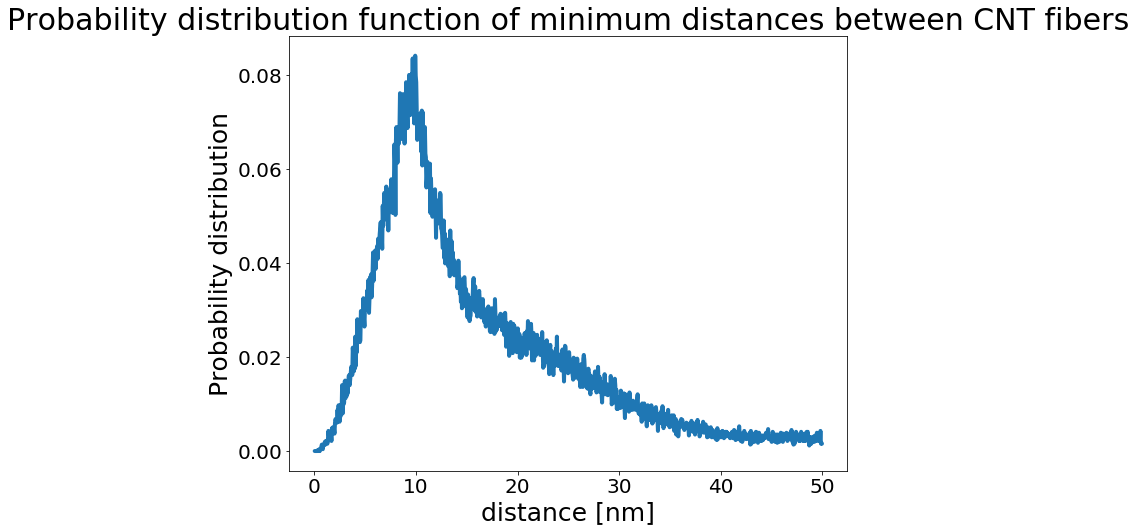

In [16]:
def min_neighbor_distance(n=1000):
    assert n <= len(tubes)
    
    min_dist = np.full((n,n),1.e4)

    for i, t1 in enumerate(tqdm(tubes[:n])):
        for j in range(i+1,n):
            t2 = tubes[j]
            temp = np.empty((t1.r_fine().shape[0],t2.r_fine().shape[0],3))
#             temp = np.empty((t2.r.shape[0],t1.r.shape[0],3))
            for d in range(3):
#                 x,y = np.meshgrid(t1.r_fine()[:,d],t2.r_fine()[:,d])
                x,y = np.meshgrid(t1._r_fine[:,d],t2._r_fine[:,d])
#                 x,y = np.meshgrid(t1.r[:,d],t2.r[:,d])
                temp[:,:,d] = x-y
            temp = np.linalg.norm(temp,axis=2)
            min_dist[i,j] = min_dist[j,i] = np.amin(temp)

    min_dist_per_cnt = np.amin(min_dist,axis=1)

    for i in range(min_dist.shape[0]):
        min_dist[i,i] = -1
        
    return min_dist_per_cnt, min_dist

# min_dist_per_cnt, pair_min_dist = min_neighbor_distance(len(tubes))

min_dist_per_cnt, pair_min_dist = min_neighbor_distance(1000)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.plot(min_dist_per_cnt)
ax.set_title("Minimum distance of a CNT fiber with a neighboring CNT")


hist_min_dist, bins = np.histogram(pair_min_dist,bins=1000, range=(0,50), density=True)
# hist_min_dist, bins = np.histogram(pair_min_dist,bins=1000, range=(0,200), density=True)
bins = (bins[:-1]+bins[1:])/2

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
_ = ax.plot(bins, hist_min_dist)
ax.set_title("Probability distribution function of minimum distances between CNT fibers")
ax.set_xlabel("distance [nm]")
ax.set_ylabel("Probability distribution")


## Create individual CNTs
Start by creating a hexagonal packed lattice that fits inside the fiber diameter

number of cnts per fiber: (43, 2)


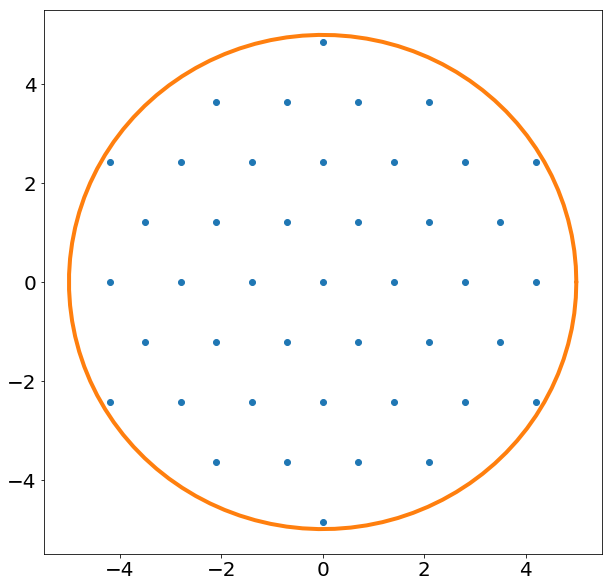

In [20]:
fiber_diameter = 5
cnt_diameter = 1.4
coor = util.HCP_coordinates(fiber_diameter, cnt_diameter)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(coor[:,0], coor[:,1], 'o')

theta = np.linspace(0,2*np.pi,100)
x = fiber_diameter*np.cos(theta)
y = fiber_diameter*np.sin(theta)
ax.plot(x,y)

print("number of cnts per fiber: {}".format(coor.shape))

### displacement normal to axis

Next, create each CNT by displacing each CNT normal to the axis of fiber, according to the HCP lattice that we created in the previous step.

In [21]:
n_fiber = len(tubes)
cnt_per_fiber = coor.shape[0]
coor_per_cnt = tubes[0].r_fine().shape[0]

cnt_pos = np.empty((n_fiber, cnt_per_fiber, coor_per_cnt, 3))
cnt_orient = np.empty((n_fiber, cnt_per_fiber, coor_per_cnt, 3))

for f, t in enumerate(tqdm(tubes[:n_fiber])):
    norm_vecs = t.tangent_vec()
    a1, a2, a3 = util.cartesian_basis_vector(norm_vecs[0])

    r_fine = t.r_fine()

    for i, vec in enumerate(norm_vecs):
        axis = np.cross(a3,vec)
        alpha = np.arcsin(np.linalg.norm(axis)) 
        qt = util.get_quaternion(axis,alpha)
        Rot = util.rotation_from_quaternion(qt)

        a1 = np.matmul(Rot,a1.T).T
        a2 = np.matmul(Rot,a2.T).T
        a3 = vec

        cnt_pos[f, :, i, :] = r_fine[i] + np.matmul(coor,np.vstack((a1,a2)))
        cnt_orient[f, :, i, :] = a3

100%|██████████| 3790/3790 [00:57<00:00, 66.36it/s]


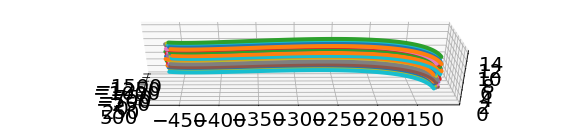

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_aspect('equal')

for f in range(1):
    for r in cnt_pos[f,:,:,:]:
        ax.plot(r[:,2],r[:,0], r[:,1])
ax.set_xlim([-1500,500])
# ax.set_ylim([-500,50])
# _ = ax.set_zlim([0,20])

# ax.view_init(elev=10., azim=np.pi/2)
ax.view_init(azim=-np.pi/4)

In [30]:
data = []

for f in range(1):
    for r in cnt_pos[f,:,:,:]:
#         ax.plot(r[:,2],r[:,0], r[:,1])
        
        trace = go.Scatter3d(
            x=r[:,2], y=r[:,0], z=r[:,1],
            marker=dict(
                size=1,
                colorscale='Viridis',
            ),
            line=dict(
                width=10
            )
        )
    
        data.append(trace)

layout = dict(
#     width=800,
#     height=700,
    autosize=True,
    title='Iris dataset',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.02 ),
        aspectmode = 'manual'
    ),
)

fig = go.Figure(data=data, layout=layout)
plo.plot(fig,filename=os.path.join(directory,"temp-pyplot.html"))

'file:///Users/amirhossein/research/cnt_mesh_fiber/temp-pyplot.html'

### Chop the CNT coordinates to make variable length CNTs
The distribution function for the length of individual CNTs is log-normal.

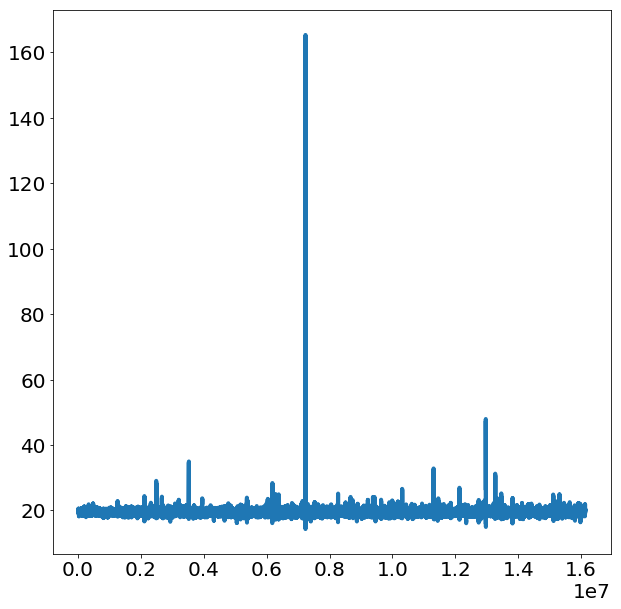

In [14]:
# n_total_cnt = n_fiber * cnt_per_fiber
# cnt_pos = np.reshape(cnt_pos,(n_total_cnt, coor_per_cnt, 3))
# cnt_orient = np.reshape(cnt_orient,(n_total_cnt, coor_per_cnt, 3))

# dist = np.linalg.norm(np.diff(cnt_pos,axis=1),axis=2)
# dist = dist.flatten()
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1,1,1)
# ax.plot(dist)

# cnt_pos = np.reshape(cnt_pos, (n_total_cnt*coor_per_cnt, 3))
# cnt_orient = np.reshape(cnt_orient, (n_total_cnt*coor_per_cnt, 3))

# directory = os.path.expanduser("~/research/cnt_mesh_fiber")
# filename = os.path.join(directory, "single_cnt.pos.dat")
# np.savetxt(filename, cnt_pos)

# filename = os.path.join(directory, "single_cnt.orient.dat")
# np.savetxt(filename, cnt_orient)


n_total_cnt = n_fiber * cnt_per_fiber
cnt_pos = np.reshape(cnt_pos,(n_total_cnt, coor_per_cnt, 3))
cnt_orient = np.reshape(cnt_orient,(n_total_cnt, coor_per_cnt, 3))

dist = np.linalg.norm(np.diff(cnt_pos,axis=1),axis=2)
dist = dist.flatten()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(dist)

# cnt_pos = np.reshape(cnt_pos, (n_total_cnt*coor_per_cnt, 3))
# cnt_orient = np.reshape(cnt_orient, (n_total_cnt*coor_per_cnt, 3))

header = "ARMA_MAT_TXT_FN008\n{} {}".format(cnt_pos[:,:,0].shape[0],cnt_pos[:,:,0].shape[1])
fmt = "%+.4e"
cmts = ""

directory = os.path.expanduser("~/research/cnt_mesh_fiber")
filename = os.path.join(directory, "single_cnt.pos.x.dat")
np.savetxt(filename, cnt_pos[:,:,0], header=header, fmt=fmt, comments=cmts)

filename = os.path.join(directory, "single_cnt.pos.y.dat")
np.savetxt(filename, cnt_pos[:,:,1], header=header, fmt=fmt, comments=cmts)

filename = os.path.join(directory, "single_cnt.pos.z.dat")
np.savetxt(filename, cnt_pos[:,:,2], header=header, fmt=fmt, comments=cmts)

filename = os.path.join(directory, "single_cnt.orient.x.dat")
np.savetxt(filename, cnt_orient[:,:,0], header=header, fmt=fmt, comments=cmts)

filename = os.path.join(directory, "single_cnt.orient.y.dat")
np.savetxt(filename, cnt_orient[:,:,1], header=header, fmt=fmt, comments=cmts)

filename = os.path.join(directory, "single_cnt.orient.z.dat")
np.savetxt(filename, cnt_orient[:,:,2], header=header, fmt=fmt, comments=cmts)

# ewald summation for finding what is short range ans what 

In [16]:
ar1 = np.array([0,1,2])
ar2 = np.array([3,4,5])
ar3 = np.array([6,7,8])

a1 = np.array([0,1,2,3,4,5,6,7])
a1 = np.reshape(a1,[2,2,2])

t1=0
t2=1
t3=2

np.savetxt("test.txt",a1)

ValueError: Expected 1D or 2D array, got 3D array instead